<a href="https://colab.research.google.com/github/flarp1905/DU-CoLab/blob/main/20260212_In_class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#resets tensor flow
!pip -q install tensorflow scikit-learn pandas matplotlib

In [3]:
#use 2025.07
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [4]:
print(tf.__version__)

2.19.0


In [9]:
#import data
USE_SYNTHETIC = True
CSV_PATH = "network_traffic.csv"
#use a random # gen to increase entropy in model to help reduce randomness
rng = np.random.default_rng(42) #random number generator - seeded with #42 so each iteration is repeatable
#grab data - we going to make it up! synthetic network telemetry

if (not USE_SYNTHETIC) and os.path.exists(CSV_PATH): #this makes it variable to make it easy to get data
  df = pd.read_csv(CSV_PATH)
  assert "label" in df.columns
  X = df.drop(columns=["Label"])
  Y = df["label"].astype(int)
  print(f"Loaded {CSV_PATH} with shape {df.shape}")
else:
  n = 12000 #randomly plucked number of data to build out
  df = pd.DataFrame(
      {
          "packet_size_mean": rng.normal(600, 200, n).clip(64, 1500), #making data like real world....
          "packets_per_second": rng.gamma(2.0, 10.0, n),
          "bytes_out": rng.lognormal(8.5, 0.7, n),
          "bytes_in": rng.lognormal(8.3, 0.7, n),
          "conn_rate": rng.gamma(1.8, 2.5, n),
          "failed_logins": rng.poisson(6, n),
          "dns_queries": rng.poisson(3, n),
          "unique_destination_ports": rng.poisson(3, n),
          "tls_handshake_errors": rng.poisson(0.05, n)
      }
  )

#mimic some real world stuff
#credential stuffing + scanning + exfil patterns

score = (
    0.9 * np.tanh((df["failed_logins"] - 1) / 1.5) +
    0.7 * np.tanh((df["unique_destination_ports"] - 6) / 2) +
    0.6 * np.tanh((df["conn_rate"] - 8) /4) +
    0.4 * np.tanh((df["bytes_out"] - 9) / 0.8) -
    0.3 * np.tanh((df["dns_queries"] - 4) / 4) +
    0.15 * rng.normal(0, 1, n)
)

#sample labels
p_attack = 1 / (1 + np.exp(-score)) #propability of attack given our "data"
y = (rng.random(n) < p_attack).astype(int)
X = df

print("Synthetic datase:", X.shape, "Label rate", y.mean().round(3))
#
df_preview = X.copy()
df_preview["Label"] = y
df_preview.head()


Synthetic datase: (12000, 9) Label rate 0.61


,packet_size_mean,packets_per_second,bytes_out,bytes_in,conn_rate,failed_logins,dns_queries,unique_destination_ports,tls_handshake_errors,Label
0,660.943416,12.978692,4198.962931,8776.757495,3.356717,7,0,2,0,1
1,392.003179,5.232173,6385.829555,5895.513659,1.214466,1,4,6,0,0
2,750.090239,19.132634,2805.180329,1945.022544,0.634594,5,4,1,0,0
3,788.112943,4.068290,10580.978164,7558.569246,3.852302,7,4,3,0,1
4,209.792962,9.768431,2932.368941,2200.923440,1.133873,7,4,1,0,0


In [11]:
#split train / test
# standardScaler (we have to get the data to be roughly similiar)

X_train, X_test, y_train, y_test  = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

print("Train sharep:", X_train_s.shape, "Test share", X_test_s.shape)
print("ATtack rate (train):", y_train.mean().round(3), "Attack rate (test):", y_test.mean().round(3))

Train sharep: (8400, 9) Test share (3600, 9)
ATtack rate (train): 0.61 Attack rate (test): 0.61


In [14]:
#single neuron
#logistic regression as a 1 layer NN

# perceptron-style classifier
#linear boundry -> feature space

baseline = tf.keras.Sequential([
    tf.keras.layers.Dense(1, activation="sigmoid", input_shape=(X_train_s.shape[1],))
])

baseline.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=11e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

hist_base = baseline.fit(
    X_train_s, y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=256,
    verbose=0
)

base_eval = baseline.evaluate(X_test_s, y_test, verbose=0)
print(f"Test Loss: {base_eval[0]:.4f}, Test accuracy: {base_eval[1]:.4f}")
#

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test Loss: 0.6479, Test accuracy: 0.6192


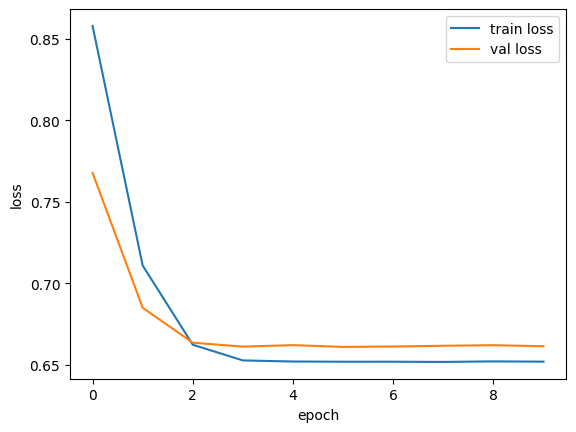

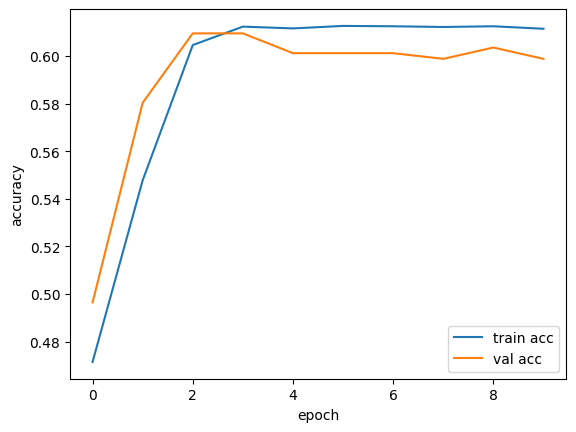

In [26]:
#plotting
# ???????????
plt.figure()
plt.plot(hist_base.history["loss"], label="train loss")
plt.plot(hist_base.history["val_loss"], label="val loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

plt.figure()
plt.plot(hist_base.history["accuracy"], label="train acc")
plt.plot(hist_base.history["val_accuracy"], label="val acc")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.show()

In [20]:
#multilayer NN (non-linear model)
#hidden layers
#ReLu activations
#this is what we are training the model to see:
  #scanning + auth failures + burst connections
  #excil byte patterns + protocol anomalies
  #these are signs of malicious behavior
#use dropout here to reduce overfitting BS!

model = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation="relu", input_shape=(X_train_s.shape[1],)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(8, activation="relu"),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

hist = model.fit(
    X_train_s, y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=256,
    verbose=0,
    callbacks=[early_stop]
)

nn_eval = model.evaluate(X_test_s, y_test, verbose=0)
print(f"NN test loss {nn_eval[0]:.4f} accuracy={nn_eval[1]:.4f}")


NN test loss 0.6544 accuracy=0.6106


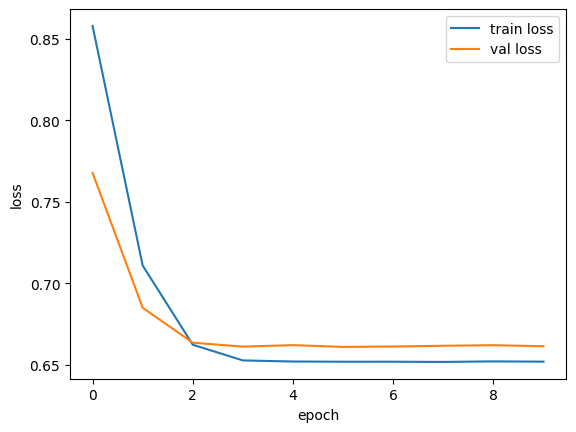

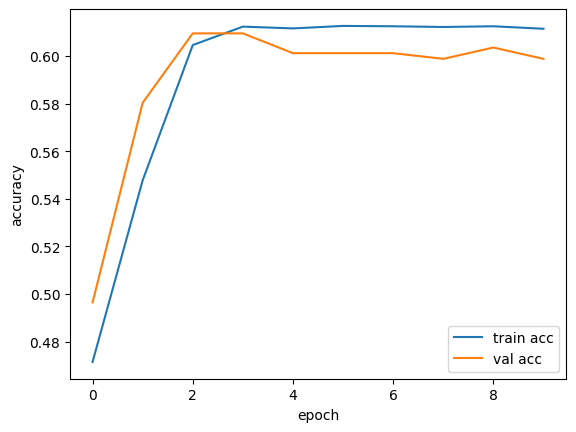

In [27]:
#plotting missed it again!
plt.figure()
plt.plot(hist_base.history["loss"], label="train loss")
plt.plot(hist_base.history["val_loss"], label="val loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

plt.figure()
plt.plot(hist_base.history["accuracy"], label="train acc")
plt.plot(hist_base.history["val_accuracy"], label="val acc")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.show()

In [24]:
#cyber sec false negative - missed attacks
#falsce positives - overwhelm waste time
#confusion matric
#precision / recall / f1 score
#ROC AUC

y_prob = model.predict(X_test_s, verbose = 0).ravel()
y_pred = (y_prob >= 0.5).astype(int)

print(classification_report(y_test, y_pred, digits=4))
#print(classific(y_test, y_pred, digits=4))

NameError: name 'classification_report' is not defined

In [25]:
#charting the ROC curver

# fpr, tpr, thresholds = roc_curve(y_test, y_prob)
# plt.plot(
# plt.show()

In [28]:
#default threshold 0.5
# higher recall catch more attacks at more alerts
# higher precision (fewer alerts) at cost of missing some attacks
#maximize F1 score - prioritizing recall

from sklearn.metrics import f1_score, precision_score, recall_score

ths = np.linspace(0.05, 0.95, 19)
rows = []

for th in ths:
  yp = (y_prob >= th).astype(int)
  rows.append({
      "threshod": th,
      "precision": precision_score(y_test, yp),
      "recall": recall_score(y_test, yp),
      "f1": f1_score(y_test, yp)
  })

thrs_df = pd.DataFrame(rows)
thrs_df.sort_values("f1", ascending=True)


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,threshod,precision,recall,f1
18,0.95,0.000000,0.000000,0.000000
17,0.90,1.000000,0.000455,0.000910
16,0.85,0.700000,0.003186,0.006343
15,0.80,0.818182,0.016386,0.032129
14,0.75,0.795918,0.035503,0.067974
13,0.70,0.808271,0.097861,0.174584
12,0.65,0.764045,0.216659,0.337589
11,0.60,0.700276,0.461538,0.556379
10,0.55,0.630729,0.870733,0.731549
7,0.40,0.610278,1.000000,0.757978


In [ ]:
best = thr_df.loc[thr_df["f1"].idxmax()]
best_th = float(best["threshold"].round)